In [1]:
"""
A noise analysis of MAXCUT using Qiskit Aer's NoiseModel
"""

%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

In [2]:
# Importing basic Qiskit
import numpy as np
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer
from qiskit.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

# Import from Qiskit Aqua algorithm module
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle

In [3]:
# Generating the butterfly graph with 5 nodes 
n     = 5
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

#Below code snippet may not run due to it being depreciated by Matplotlib package
# Generate plot of the Graph
# colors       = ['r' for node in G.nodes()]
# default_axes = plt.gca()
# pos          = nx.spring_layout(G)

# nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

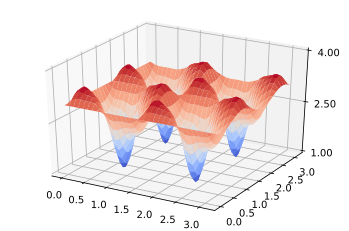

In [4]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


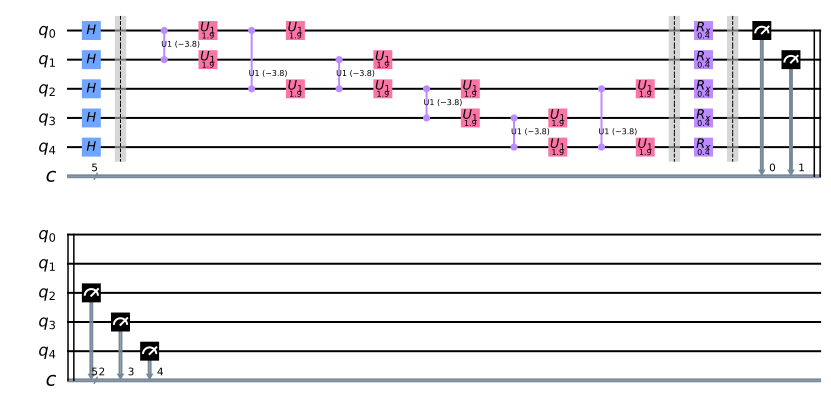

In [5]:
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cu1(-2*gamma, k, l)
    QAOA.u1(gamma, k)
    QAOA.u1(gamma, l)
    
# then apply the single qubit X - rotations with angle beta to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))

# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw(output = 'mpl', scale = 0.45)

In [6]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

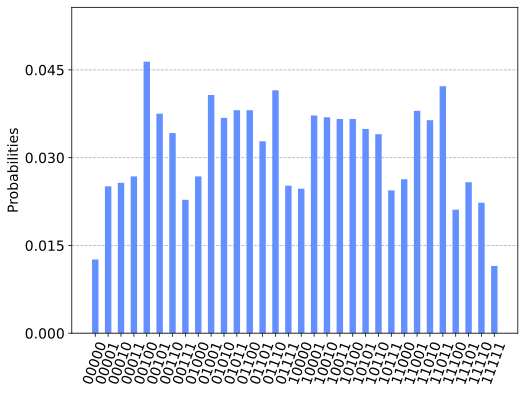

In [7]:
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(QAOA, backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.31 while the true value is M1 = 3.43 

The approximate solution is x* = 10011 with C(x*) = 4 

The cost function is distributed as: 



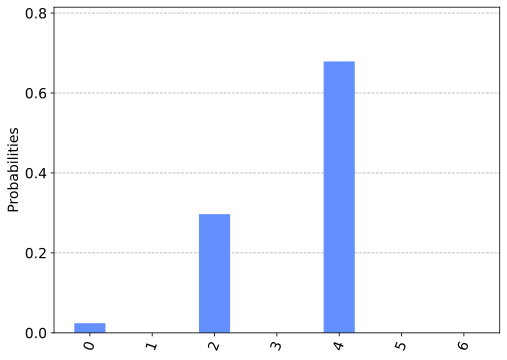

In [ ]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

In [9]:
def create_noise_model(n_qubits):
    #Parameters of noise
    p_bit_flip = {
        'p_reset' : 0.05,
        'p_meas' : 0.15
    }
    
    u2_error_limits = [3.94e-4, 7.54e-3]
    cx_error_limits = [2e-2, 8e-2]
    
    T_limits = [[11.69e3, 86.12e3], [18.02e3, 132.59e3]] # T2 <= 2*T1    
    instruction_times = {
        #times in nanoseconds
        'time_u1' : 20,
        'time_u2' : 100,
        'time_u3' : 200,
        'time_cx' : 600,
        'time_reset' : 1000,
        'time_measure' : 1000
    }
    #####################################
    T1s = np.random.rand(n_qubits)
    T2s = np.random.rand(n_qubits)
    u2_errors = np.random.rand(n_qubits)
    cx_errors = np.random.rand(n_qubits, n_qubits)
    
    for i in range(n_qubits):
        T1s[i] = T_limits[0][0] + T1s[i]*T_limits[0][1]
        T2s[i] = T_limits[1][0] + T2s[i]*T_limits[1][1]
        u2_errors[i] = u2_error_limits[0] + u2_errors[i]*u2_error_limits[1]
        for j in range(n_qubits):
            cx_errors[i][j] = cx_error_limits[0] + cx_errors[i][j]*cx_error_limits[1]
        
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(n_qubits)]) # Truncate random T2s <= T1s
    
    #Quantum error objects
    bit_flip_error_reset = pauli_error([('X', p_bit_flip['p_reset']), ('I', 1 - p_bit_flip['p_reset'])])
    bit_flip_error_meas = pauli_error([('X', p_bit_flip['p_meas']), ('I', 1 - p_bit_flip['p_meas'])])
    bit_flip_errors_u2 = [pauli_error([('X', e1), ('I', 1 - e1)]) for e1 in u2_errors]
    
    bit_flip_errors_cx_single = [[pauli_error([('X', e1), ('I', 1-e1)]) for e1 in sub_array]
                                                                            for sub_array in cx_errors]
    bit_flip_errors_cx = [[qe1.tensor(qe1) for qe1 in sub_array] for sub_array in bit_flip_errors_cx_single]
    
    thermal_errors_reset = [thermal_relaxation_error(t1, t2, instruction_times['time_reset'])
                for t1, t2 in zip(T1s, T2s)]
    thermal_errors_measure = [thermal_relaxation_error(t1, t2, instruction_times['time_measure'])
                      for t1, t2 in zip(T1s, T2s)]
    thermal_errors_u1  = [thermal_relaxation_error(t1, t2, instruction_times['time_u1'])
                  for t1, t2 in zip(T1s, T2s)]
    thermal_errors_u2  = [thermal_relaxation_error(t1, t2, instruction_times['time_u2'])
                  for t1, t2 in zip(T1s, T2s)]
    thermal_errors_u3  = [thermal_relaxation_error(t1, t2, instruction_times['time_u3'])
                  for t1, t2 in zip(T1s, T2s)]
    thermal_errors_cx = [[thermal_relaxation_error(t1a, t2a, instruction_times['time_cx']).expand(
                 thermal_relaxation_error(t1b, t2b, instruction_times['time_cx']))
                  for t1a, t2a in zip(T1s, T2s)]
                   for t1b, t2b in zip(T1s, T2s)]
    
    
    
    noise_model = NoiseModel()    
    
    for i in range(n_qubits):
        noise_model.add_quantum_error(bit_flip_error_reset, "reset", [i], warnings = False)
        noise_model.add_quantum_error(bit_flip_error_meas, "measure", [i], warnings = False)
        noise_model.add_quantum_error(thermal_errors_reset[i], "reset", [i], warnings = False)
        noise_model.add_quantum_error(thermal_errors_measure[i], "measure", [i], warnings = False)
        noise_model.add_quantum_error(thermal_errors_u1[i], "u1", [i], warnings = False)
        noise_model.add_quantum_error(thermal_errors_u2[i], "u2", [i], warnings = False)
        noise_model.add_quantum_error(thermal_errors_u3[i], "u3", [i], warnings = False)
        noise_model.add_quantum_error(bit_flip_errors_u2[i], ['u2'], [i], warnings = False)
        for j in range(n_qubits):
            noise_model.add_quantum_error(thermal_errors_cx[i][j], "cx", [i, j], warnings = False)
            noise_model.add_quantum_error(bit_flip_errors_cx[i][j], ['cx'], [i, j], warnings = False)
            
    return noise_model

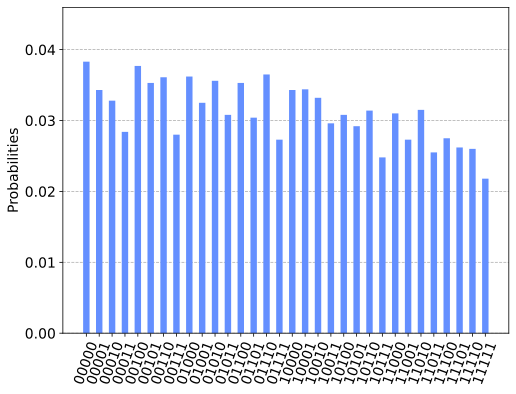

In [10]:
noise_custom = create_noise_model(5)

backend = Aer.get_backend('qasm_simulator')
shots        = 10000

simulate     = execute(QAOA, backend=backend, 
                       basis_gates = noise_custom.basis_gates,
                       noise_model = noise_custom, shots=shots)

QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.05 while the true value is M1 = 3.43 

The approximate solution is x* = 10011 with C(x*) = 4 

The cost function is distributed as: 



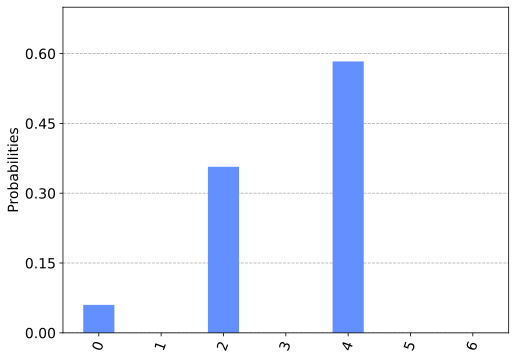

In [ ]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)